In [1]:
%pip install -q tf-nightly

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import sys
import argparse
import json
import itertools
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import IPython.display as display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [11]:
tf.__version__

'2.4.0-dev20200815'

In [12]:
# rgb edited image 
DATA_DIR_IN = "./Data/raw_data_in/"

In [13]:
def read_data(data_dir):
    
    fpaths = []
    labels = []
    data_map = {} # {'filename':[path,label]}

    for fname in os.listdir(data_dir):
        if '.DS_Store' in fname:
            continue
        path_label = ['','']
        fpath = os.path.join(data_dir, fname)
        image_label, ftype = fname.split(".")
                
        if not image_label in data_map:
            data_map[image_label] = path_label
        #print("name: {}\tlabel: {}".format(image_label, ftype))
        
        if ftype == 'txt':
            f = open(fpath, "r")
            label = f.readlines()
            # label is list with len 1
            f.close()
            labels.append(label[0])
            data_map[image_label][0] = label[0]
        else:
            fpaths.append(fpath)
            data_map[image_label][1] = fpath
            

        #print("fpath: {}, label: {}".format(fpath, label))
    
    for key in data_map:
        print("key: {}, label path: {}".format(key, data_map[key])) 
        
    labels = np.array(labels)
    fpaths = np.array(fpaths)
     
    print("shape of fpaths: {}\tshape of labels: {}".format(fpaths.shape, 
        labels.shape))
    return data_map #fpaths, labels

In [14]:
data_map = read_data(DATA_DIR_IN)

key: (6894), label path: ['05590', './Data/raw_data_in/(6894).jpg']
key: (6895), label path: ['04011', './Data/raw_data_in/(6895).jpg']
key: (6897), label path: ['03879', './Data/raw_data_in/(6897).jpg']
key: (6898), label path: ['18645', './Data/raw_data_in/(6898).jpg']
key: (6901), label path: ['01309', './Data/raw_data_in/(6901).jpg']
key: (6902), label path: ['03562', './Data/raw_data_in/(6902).jpg']
key: (6905), label path: ['09488', './Data/raw_data_in/(6905).jpg']
key: (6907), label path: ['10027', './Data/raw_data_in/(6907).jpg']
key: (6909), label path: ['06144', './Data/raw_data_in/(6909).jpg']
key: (6910), label path: ['53058', './Data/raw_data_in/(6910).jpg']
key: (6911), label path: ['00117', './Data/raw_data_in/(6911).jpg']
key: (6912), label path: ['21082', './Data/raw_data_in/(6912).jpg']
key: (6913), label path: ['02649', './Data/raw_data_in/(6913).jpg']
key: (6914), label path: ['00826', './Data/raw_data_in/(6914).jpg']
key: (6915), label path: ['00489', './Data/raw_d

In [15]:
len(data_map)

999

In [16]:
def get_dataset(data_map):
  
    dataset = np.ndarray(shape=(len(data_map), 100, 100), dtype='float32')
    print(dataset.shape)
    labels = np.ones(shape=(len(data_map), 5), dtype='int') * 10 
    
    width_height = (100, 100) 
    for i, key in enumerate(data_map):
        path_label = data_map[key]
        image = Image.open(path_label[1])
        label = path_label[0]
        label_array = []
        for n, num in enumerate(label):
            #print(n, num )
            label_array.append(num)
            
        resized_img = image.resize(width_height)
        #print(type(resized_img))
        #img_array =np.array(resized_img, dtype='float32')
        #resized_img = normalization(resized_img)
        img_array = rgb2gray(resized_img)
        #img_array = img_array.reshape(img_array.shape[0], img_array.shape[1], 1)
        # print(img_array.shape)
        dataset[i,:,:] = img_array[:,:]
        ds = dataset #[..., np.newaxis]
         #self.labels[i,0] = len(boxes)
        labels[i,:] = label_array
    print('dataset:',ds.shape)
    print('labels:',labels.shape)
    return ds, labels
        
def normalization(img):
    im = rgb2gray(img) # RGB to greyscale
    mean = np.mean(im, dtype='float32')
    std = np.std(im, dtype='float32', ddof=1)
    return (im - mean) / std  
    
def rgb2gray(img):
    return np.dot(np.array(img, dtype='float32'), [0.299, 0.587, 0.114])        

In [17]:
train_dataset, train_labels = get_dataset(data_map)

(999, 100, 100)
dataset: (999, 100, 100)
labels: (999, 5)


[0 4 0 1 1]


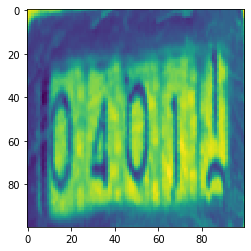

In [18]:
plt.imshow(train_dataset[1,:,:])
print(train_labels[1])

In [19]:
train_dataset = train_dataset[..., np.newaxis]

In [20]:
def prepare_final_data(x_train, y_train):
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)
    print(x_train.shape[0], "train samples")
    print(x_valid.shape[0], "valid samples")
    return {
        "x_train": x_train,
        "y_train": y_train,
        "x_valid": x_valid,
        "y_valid": y_valid
    }

In [21]:
dataset = prepare_final_data(train_dataset, train_labels)

799 train samples
200 valid samples


In [22]:
x_train, y_train, x_valid, y_valid = dataset["x_train"], dataset["y_train"], dataset["x_valid"], dataset["y_valid"]

In [23]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(799, 100, 100, 1) (799, 5) (200, 100, 100, 1) (200, 5)


In [24]:
batch_size = 32
img_height = 100
img_width = 100

In [25]:
class_names = train_ds.class_names
print(class_names)

NameError: name 'train_ds' is not defined

the first 9 images from the training dataset.

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

NameError: name 'train_ds' is not defined

<Figure size 720x720 with 0 Axes>

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

NameError: name 'train_ds' is not defined

In [28]:
model = tf.keras.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The third convolution
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

#model.summary()

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  x_train, y_train,
  batch_size=batch_size,
  validation_data=(x_valid, y_valid),
  epochs=100
)


Epoch 1/100
25/25 [==============================] - 9s 342ms/step - loss: 23.0292 - accuracy: 0.2786 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 2/100
25/25 [==============================] - 8s 333ms/step - loss: 23.6509 - accuracy: 0.3333 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 3/100
25/25 [==============================] - 8s 310ms/step - loss: 23.2437 - accuracy: 0.3626 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 4/100
25/25 [==============================] - 8s 309ms/step - loss: 23.2800 - accuracy: 0.3229 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 5/100
25/25 [==============================] - 7s 292ms/step - loss: 22.7319 - accuracy: 0.3506 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 6/100
25/25 [==============================] - 8s 303ms/step - loss: 23.7445 - accuracy: 0.3388 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 7/100
25/25 [==============================] - 7s 282ms/step - loss: 23.4831 - accuracy: 0.3086 - val_loss: 23.0182 - val_ac

25/25 [==============================] - 7s 284ms/step - loss: 22.9011 - accuracy: 0.3469 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 58/100
25/25 [==============================] - 7s 298ms/step - loss: 23.3979 - accuracy: 0.3379 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 59/100
25/25 [==============================] - 7s 287ms/step - loss: 23.3291 - accuracy: 0.3184 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 60/100
25/25 [==============================] - 7s 281ms/step - loss: 23.2512 - accuracy: 0.3281 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 61/100
25/25 [==============================] - 7s 281ms/step - loss: 23.5897 - accuracy: 0.2957 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 62/100
25/25 [==============================] - 7s 281ms/step - loss: 22.9891 - accuracy: 0.3488 - val_loss: 23.0182 - val_accuracy: 0.2950
Epoch 63/100
25/25 [==============================] - 7s 285ms/step - loss: 23.3747 - accuracy: 0.3347 - val_loss: 23.0182 - val_accuracy

In [ ]:
model.save("mymodel.h5")

In [ ]:
DATA_DIR_TEST = "./data/raw_data_in/"

In [ ]:
from keras.preprocessing import image
# predicting images
path = os.path.join(DATA_DIR_TEST,"(6894).jpg")

img = image.load_img(path, target_size=(100, 100))
print(img.size)
print(type(img))
img = rgb2gray(img)

x = image.img_to_array(img)
print('x.shape: ', x.shape)
#x1 = np.expand_dims(img, axis=-1)
#print(x1.shape)
x = np.expand_dims(x, axis=0)
#print(x.shape)

images = np.vstack([x]) # vertically stack together
classes = model.predict(images)
print(path)
print(classes)

In [ ]:
np.argmax(classes)